In [1]:
import torch
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

from edunets import functions
from edunets.nn import Linear
from edunets.tensor import Tensor

(<matplotlib.image.AxesImage at 0x7fa34e1209d0>, 5)

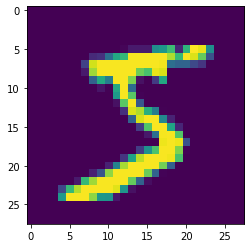

In [2]:
# load the mnist dataset

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

plt.imshow(X_train[0]), Y_train[0]

In [3]:
class EduNet1:
    def __init__(self):
        self.l1 = Tensor.uniform(784, 128, requires_grad=True, label="L1")
        self.l2 = Tensor.uniform(128, 10, requires_grad=True, label="L2")

    def __call__(self, x):
        x = x @ self.l1
        x = x.relu()
        x = x @ self.l2
        return x

# Mean Square Error
def MSELOSS(out, Y):
    return (out * Y).mean()

# Stochastic gradient descent
class SGD:
    def __init__(self, params, lr=0.001):
        self.lr = lr
        self.params = params

    def step(self):
        for t in self.params:
            # is assign really necessary ?
            t.assign(t - t.grad * self.lr)

    def zero_grad(self):
        for param in self.params:
            param.grad = None

In [4]:
model = EduNet1()

optim = SGD([model.l1, model.l2], lr=0.001)
batch_size = 128
losses, accuracies = [], []

print(model.l1)

for i in (t := trange(1)):
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))

    X = Tensor(X_train[samp].reshape((-1, 28*28)))

    Y = Tensor(Y_train[samp])

    out = model(X); out.label = "out"
    
    cat = functions.argmax(out, axis=1)
    
    accuracy = (cat == Y).mean()
    
    loss = MSELOSS(out, Y)
    
    optim.zero_grad()
    
    loss.backward()
    
    optim.step()
    
    losses.append(loss.data)
    
    accuracies.append(accuracy.data)
    
    t.set_description("loss %.2f accuracy %.2f" % (loss.data, accuracy.data))

print(model.l1)
loss.graph


tensor([[-0.8496051 ,  0.1531905 ,  0.6356824 , ...,  0.8275709 ,
        -0.83430433, -0.3014922 ],
       [-0.14055187,  0.10349853, -0.61574835, ...,  0.782805  ,
        -0.27391925,  0.534228  ],
       [-0.5215348 , -0.14476962, -0.08801257, ...,  0.45679036,
        -0.6943441 , -0.15163507],
       ...,
       [ 0.33190966,  0.3385526 , -0.7434831 , ..., -0.8081201 ,
        -0.20051774,  0.3259416 ],
       [ 0.19371495,  0.22489806, -0.43722644, ...,  0.38564903,
         0.9978592 ,  0.8465519 ],
       [-0.3727893 , -0.4351056 , -0.15815148, ..., -0.03974785,
        -0.8251048 ,  0.34175813]], dtype=float32, requires_grad=True)


  0%|          | 0/1 [00:00<?, ?it/s]

(128, 128) (128, 10) (128,)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 128)